## Import modules

In [606]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
le = LabelEncoder()
SEED = 42

## Reading dataset

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Dataset description

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту

In [560]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [5]:
data[data['sample'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  i

In [6]:
# Unique data by columns

data[data['sample'] == 1].nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
sample                  1
default                 2
dtype: int64

In [7]:
# Empty cells by columns

data[data['sample'] == 1].isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [8]:
# Main metrics of dataset

data[data['sample'] == 1].describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.0,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,1.0,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.0,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,1.0,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,1.0,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.0,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.0,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.0,1.000000


In [9]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
5887,34114,10FEB2014,GRD,M,54,N,N,0,0,-1.827616,1,50,2,3,32000,1,4,N,0,0
91209,91499,08APR2014,UGR,M,29,Y,N,0,0,-2.023538,4,80,2,3,45000,1,3,N,1,0
96439,34876,11FEB2014,SCH,F,46,N,N,0,0,-2.636620,0,50,2,3,25000,1,3,N,1,0
48353,395,03JAN2014,SCH,M,35,Y,N,0,0,-2.169664,1,60,2,3,40000,1,4,N,1,1
30046,93446,09APR2014,SCH,F,54,N,N,1,0,-1.964999,4,50,2,3,45000,2,2,N,0,0


## Function list

In [718]:
def outliers(col, col_name):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = pd.DataFrame(col[((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]).count()
    print(f'In column {outliers_count.index[0]} {outliers_count[0]} ouliers')


def percent_of_target(col1, col2):
    display(pd.crosstab(col1, col2, normalize='index'))
    

def main_daraframe_processing(data):
    # Logarithm columns
    for col in ['age', 'income']:
        data[col+'_log'] = np.log(data[col] + 1)
        
    # For Education adding NaNs column and filling NaNs by 'NOED'
    data['education_NaN'] = (data['education'].isna()).astype('int32')
    data['education'].fillna('NOED', inplace=True)
    data['cat_education'] = le.fit_transform(data['education'])
    
    # Columns for mark outliers
    for col in ['score_bki', 'income', 'bki_request_cnt']:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        data[col+'_outliers'] = ((data[col] < (Q1 - 1.5 * IQR)) 
                                 | (data[col] > (Q3 + 1.5 * IQR))).astype('int32')
    
    # Split age column to categories
    cut_bins = list([x for x in range(19, 80, 5)])
    cut_labels = list([x for x in range(len(cut_bins)-1)])
    data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels).astype('int32')
    
    # Reduce categories
    mask1 = (data['bki_request_cnt'] > 18)
    mask2 = (data['bki_request_cnt'].between(15, 18, inclusive=True))
    mask3 = (data['bki_request_cnt'].between(12, 14, inclusive=True))
    mask4 = (data['bki_request_cnt'].between(9, 11, inclusive=True))
    mask5 = (data['bki_request_cnt'].between(6, 8, inclusive=True))
    mask6 = (data['bki_request_cnt'].between(4, 5, inclusive=True))

    data.loc[mask6, 'bki_request_cnt'] = 4
    data.loc[mask5, 'bki_request_cnt'] = 5
    data.loc[mask4, 'bki_request_cnt'] = 6
    data.loc[mask3, 'bki_request_cnt'] = 7
    data.loc[mask2, 'bki_request_cnt'] = 8
    data.loc[mask1, 'bki_request_cnt'] = 9
    
    mask = (data['decline_app_cnt'] > 4)
    data.loc[mask, 'decline_app_cnt'] = 4
    
    # Combine 2 columns
    data['car_sex'] = data['sex'] + data['car']
    data['car_and_type'] = data['car'] + data['car_type']
    car_and_type_dict = {'NN': 0, 'YN': 1, 'YY': 2}
    data['car_and_type'] = data['car_and_type'].map(car_and_type_dict)
    
    # Date processing
    data['app_date'] = pd.to_datetime(data['app_date'])
    data['week_num'] = data['app_date'].dt.isocalendar().week
    data['month_num'] = data['app_date'].dt.month
    
    
    # Changing Y-N to 1-0
    for col in ['sex', 'car', 'car_type', 'foreign_passport']:
        data[col+'_num'] = (data[col] == 'Y').astype('int32')
        
    # Dummies
    dummies_lst = ['education', 'sex', 'car', 'car_type', 'good_work', 'region_rating', 'home_address', 
                   'sna', 'first_time', 'foreign_passport', 'cat_age', 'car_sex', 'car_and_type', 
                   'month_num']

    dummies_lst1 = ['education', 'good_work', 'region_rating', 'home_address', 
                    'sna', 'first_time']

    dummies_lst2 = ['education', 'car_sex', 'car_car_type', 'good_work', 'region_rating', 'home_address', 
                    'work_address', 'sna', 'first_time', 'foreign_passport']
    
    dummies_data = pd.get_dummies(data[dummies_lst], columns=dummies_lst)
    data = pd.concat([data, dummies_data], axis=1)
    
    # Deleting non-usefull columns
    drop_lst = ['education', 'sex', 'car', 'car_type', 'good_work', 'region_rating', 'home_address', 
                'work_address', 'sna', 'first_time', 'foreign_passport', 'app_date', 'cat_age', 
                'age', 'income', 'car_sex', 'month_num']
    
    drop_lst1 = ['education', 'sex', 'car', 'car_type', 'app_date', 'age', 'income', 'client_id', 
                 'car_sex', 'car_car_type', 'cat_education', 'cat_age', 'foreign_passport', 
                 'home_address', 'work_address', 'first_time', 'sna']
    
    drop_lst2 = ['education', 'sex', 'car', 'car_type', 'app_date', 'age', 'income', 'client_id', 
                 'car_sex', 'car_car_type', 'foreign_passport']
    
    data = data.drop(drop_lst, axis=1)
    
    return data


def normalize(train_data, test_data):
    scaler=RobustScaler()
    y = train_data['default'].values
    X = scaler.fit_transform(train_data.drop(columns='default', axis=1))
    test_data = scaler.fit(test_data.values)
    return X, y


def model(X_train, X_valid, y_train, y_valid, class_w=None):
    lr = LogisticRegression(solver='liblinear', max_iter=1000, class_weight=class_w)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_valid)
    y_pred_proba = lr.predict_proba(X_valid)
    
    print(f1_score(y_valid, y_pred))
    print(classification_report(y_valid, y_pred))
    print(cross_val_score(lr, X_train, y_train, scoring='f1', cv=10))
    
    roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:,1])
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

### Setup

In [11]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

### Numerical columns

#### Age

This column doen't have NaN. So, let's look at outliers and distribution by Default.

In [12]:
outliers(data[data['sample'] == 1]['age'], 'age')

In column age 0 ouliers


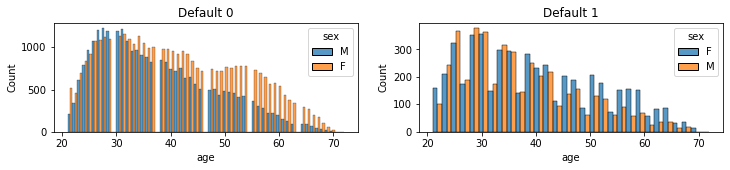

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='age', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='age', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

Intresting. Kredit for women more ofter had been approved. Denied the same.

In [14]:
print(f'Min Age is {data[data["sample"] == 1]["age"].min()}')
print(f'Max Age is {data[data["sample"] == 1]["age"].max()}')

Min Age is 21
Max Age is 72


Split it on categories by 5 years

In [15]:
cut_bins = list([x for x in range(19, 80, 5)])
cut_labels = list([x for x in range(len(cut_bins)-1)])
data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels).astype('int32')

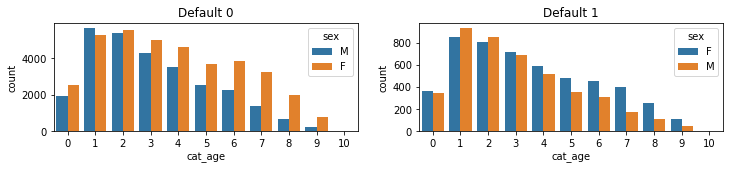

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='cat_age', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='cat_age', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [17]:
percent_of_target(data[data['sample'] == 1]['cat_age'], data[data['sample'] == 1]['default'])

default,0,1
cat_age,,
0,0.862229,0.137771
1,0.859879,0.140121
2,0.868963,0.131037
3,0.868765,0.131235
4,0.880069,0.119931
5,0.881624,0.118376
6,0.888581,0.111419
7,0.889210,0.110790
8,0.876908,0.123092


In [18]:
data['age'] = np.log(data['age'] + 1)

About equal distribution by categories over Default column.

#### score_bki

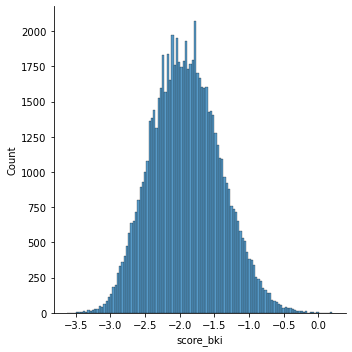

In [19]:
sns.displot(data[data['sample'] == 1]['score_bki'])
plt.show()

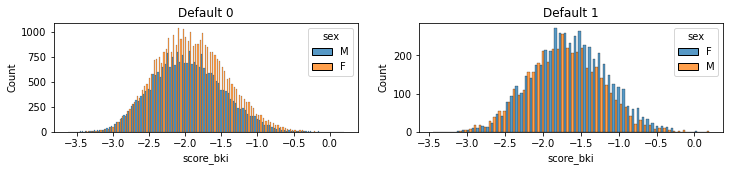

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

This column doen't have NaN. So, let's look at outliers and distribution by Default

In [21]:
outliers(data[data['sample'] == 1]['score_bki'], 'score_bki')

In column score_bki 351 ouliers


Let's make column to mark outliers.

In [22]:
Q1 = data[data['sample'] == 1]['score_bki'].quantile(0.25)
Q3 = data[data['sample'] == 1]['score_bki'].quantile(0.75)
IQR = Q3 - Q1
data['score_bki_outliers'] = ((data['sample'] == 1) & ((data['score_bki'] < (Q1 - 1.5 * IQR)) | (data['score_bki'] > (Q3 + 1.5 * IQR)))).astype('int32')

#### decline_app_cnt

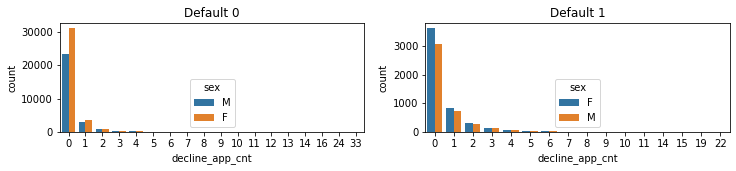

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='decline_app_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='decline_app_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

Count sum of each group

In [24]:
data[data['sample'] == 1]['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Let's group tails. Leave only 5 groups.

In [25]:
mask = (data['decline_app_cnt'] > 4)
data.loc[mask, 'decline_app_cnt'] = 4

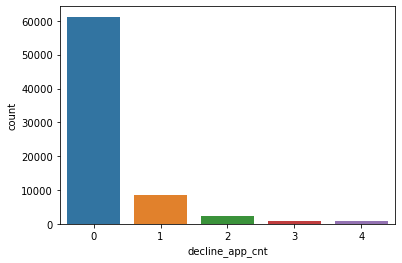

In [26]:
sns.countplot(x='decline_app_cnt', data=data[data['sample'] == 1])
plt.show()

In [27]:
percent_of_target(data[data['sample'] == 1]['decline_app_cnt'], data[data['sample'] == 1]['default'])

default,0,1
decline_app_cnt,,
0,0.890466,0.109534
1,0.812195,0.187805
2,0.756483,0.243517
3,0.726467,0.273533
4,0.703794,0.296206


#### bki_request_cnt

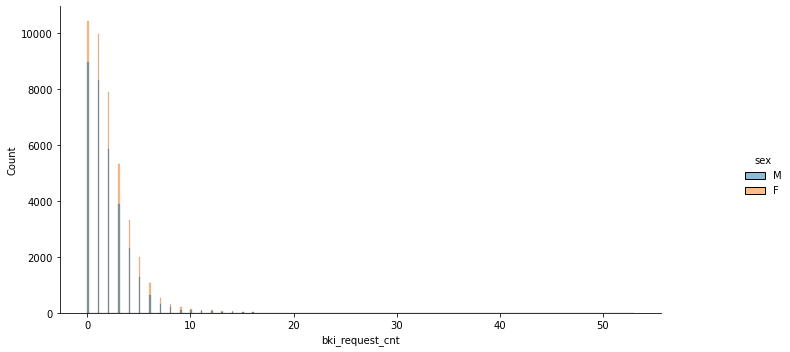

In [28]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

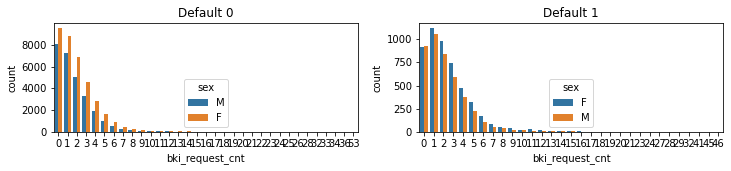

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [30]:
data[data['sample'] == 1]['bki_request_cnt'].value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [31]:
mask1 = (data['bki_request_cnt'] > 18)
mask2 = (data['bki_request_cnt'].between(15, 18, inclusive=True))
mask3 = (data['bki_request_cnt'].between(12, 14, inclusive=True))
mask4 = (data['bki_request_cnt'].between(9, 11, inclusive=True))
mask5 = (data['bki_request_cnt'].between(6, 8, inclusive=True))
mask6 = (data['bki_request_cnt'].between(4, 5, inclusive=True))

data.loc[mask6, 'bki_request_cnt'] = 4
data.loc[mask5, 'bki_request_cnt'] = 5
data.loc[mask4, 'bki_request_cnt'] = 6
data.loc[mask3, 'bki_request_cnt'] = 7
data.loc[mask2, 'bki_request_cnt'] = 8
data.loc[mask1, 'bki_request_cnt'] = 9

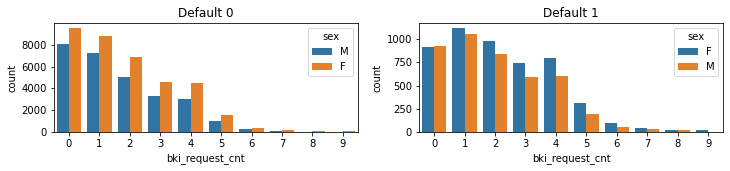

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

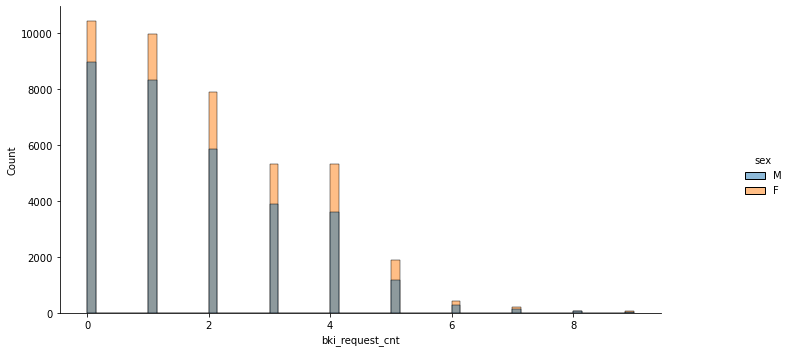

In [33]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

#### Income

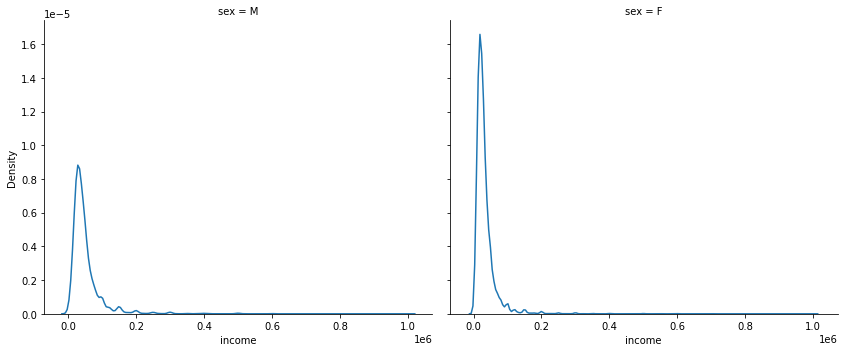

In [34]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

In [35]:
outliers(data[data['sample'] == 1]['income'], 'income')

In column income 4695 ouliers


In [36]:
Q1 = data[data['sample'] == 1]['income'].quantile(0.25)
Q3 = data[data['sample'] == 1]['income'].quantile(0.75)
IQR = Q3 - Q1
data['income_outliers'] = ((data['sample'] == 1) & ((data['income'] < (Q1 - 1.5 * IQR)) | (data['income'] > (Q3 + 1.5 * IQR)))).astype('int32')

25 quatile = 20000, 75 - 48000. Make cat column from income with step 5000. < 20000 - 0, > 48000 max cat

In [37]:
cut_income_bins = [0, 20000, 25000, 30000, 35000, 40000, 45000, 48000, 1000001]
cut_income_labels = [0, 1, 2, 3, 4, 5, 6, 7]

data['cat_income'] = pd.cut(data['income'], cut_income_bins, labels=cut_income_labels, right=False).astype('int32')

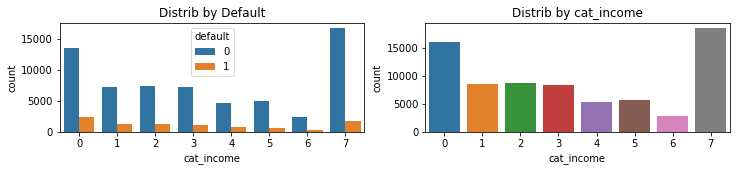

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='cat_income', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='cat_income', ax=ax[1]).set_title('Distrib by cat_income')
plt.show()

In [39]:
percent_of_target(data[data['sample'] == 1]['cat_income'], data[data['sample'] == 1]['default'])

default,0,1
cat_income,,
0,0.853437,0.146563
1,0.849900,0.150100
2,0.858661,0.141339
3,0.873969,0.126031
4,0.859730,0.140270
5,0.883493,0.116507
6,0.875133,0.124867
7,0.907273,0.092727


In [40]:
data['income'] = np.log(data['income'] + 1)

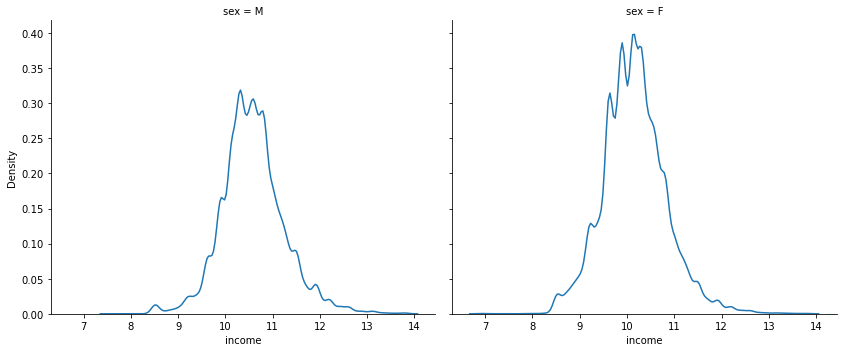

In [41]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

### Binary columns

#### sex

Convert from literal to numeric.

In [42]:
data['sex'] = (data['sex'] == 'M').astype('int32')

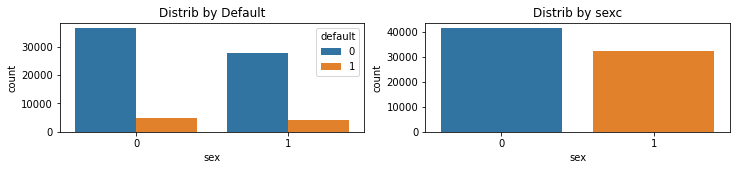

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='sex', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='sex', ax=ax[1]).set_title('Distrib by sex')
plt.show()

#### car

Convert from literal to numeric

In [44]:
data['car'] = (data['car'] == 'Y').astype('int32')

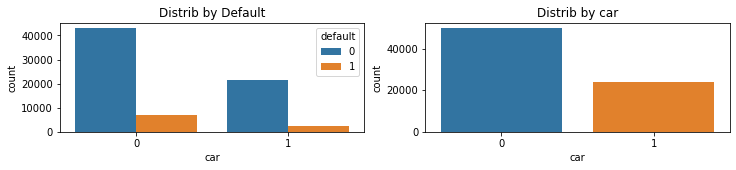

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='car', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='car', ax=ax[1]).set_title('Distrib by car')
plt.show()

#### car_type

Convert from literal to numeric

In [46]:
data['car_type'] = (data['car_type'] == 'Y').astype('int32')

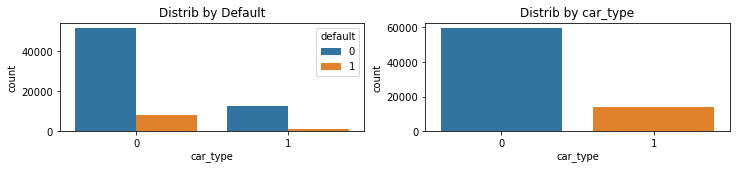

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='car_type', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='car_type', ax=ax[1]).set_title('Distrib by car_type')
plt.show()

#### good_work

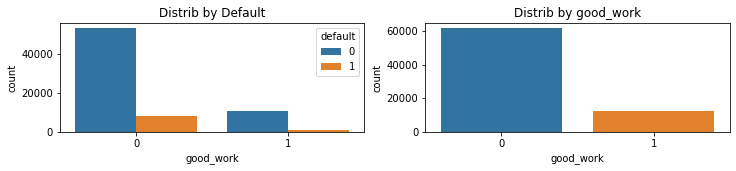

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='good_work', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='good_work', ax=ax[1]).set_title('Distrib by good_work')
plt.show()

#### foreign_passport

Convert from literal to numeric

In [49]:
data['foreign_passport'] = (data['foreign_passport'] == 'Y').astype('int32')

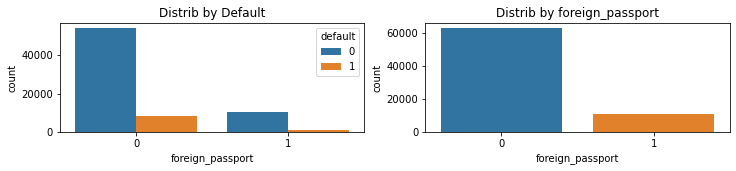

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='foreign_passport', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='foreign_passport', ax=ax[1]).set_title('Distrib by foreign_passport')
plt.show()

### Categorical columns

#### Education

In [51]:
data[(data['sample'] == 1)]['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

This column has empty cells. Count them and fill by mode. There is only 307 in train. But first I make new column with marks of empty cells (like for outliers)

In [52]:
data['education_NaN'] = (data['education'].isna()).astype('int32')

In [53]:
data['education'].fillna('NOED', inplace=True)

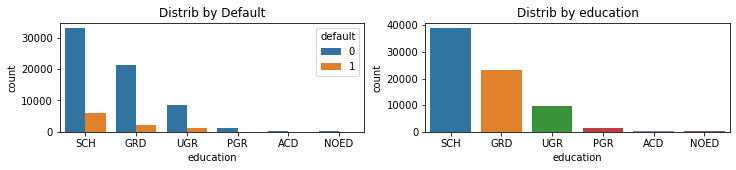

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='education', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='education', ax=ax[1]).set_title('Distrib by education')
plt.show()

In [55]:
percent_of_target(data[(data['sample'] == 1)]['education'], data[(data['sample'] == 1)]['default'])

default,0,1
education,,
ACD,0.958763,0.041237
GRD,0.909908,0.090092
NOED,0.885993,0.114007
PGR,0.935561,0.064439
SCH,0.849408,0.150592
UGR,0.868480,0.131520


Further I'll decide to do dummies or change cal names to numeric

#### first_time

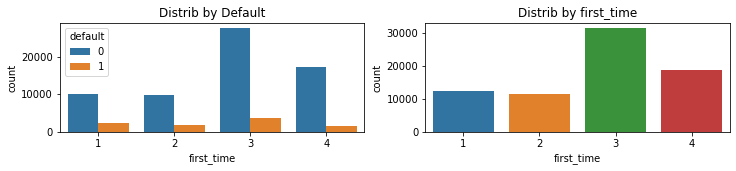

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='first_time', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='first_time', ax=ax[1]).set_title('Distrib by first_time')
plt.show()

In [57]:
percent_of_target(data[(data['sample'] == 1)]['first_time'], data[(data['sample'] == 1)]['default'])

default,0,1
first_time,,
1,0.813874,0.186126
2,0.844571,0.155429
3,0.879731,0.120269
4,0.917970,0.082030


#### sna

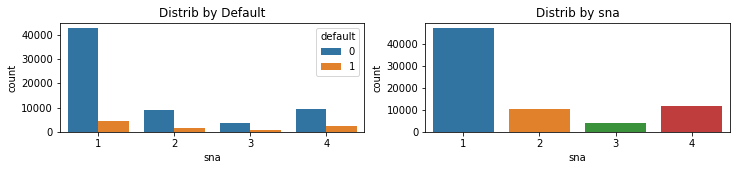

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='sna', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='sna', ax=ax[1]).set_title('Distrib by sna')
plt.show()

In [59]:
percent_of_target(data[(data['sample'] == 1)]['sna'], data[(data['sample'] == 1)]['default'])

default,0,1
sna,,
1,0.901799,0.098201
2,0.850179,0.149821
3,0.842348,0.157652
4,0.788493,0.211507


#### work_address

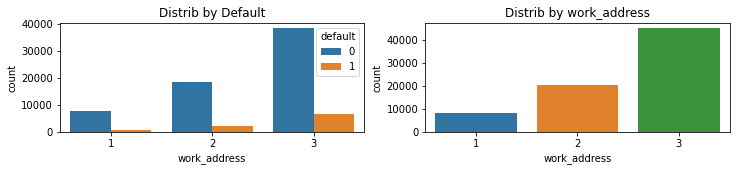

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='work_address', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='work_address', ax=ax[1]).set_title('Distrib by work_address')
plt.show()

In [61]:
percent_of_target(data[(data['sample'] == 1)]['work_address'], data[(data['sample'] == 1)]['default'])

default,0,1
work_address,,
1,0.925846,0.074154
2,0.897493,0.102507
3,0.852043,0.147957


#### home_address

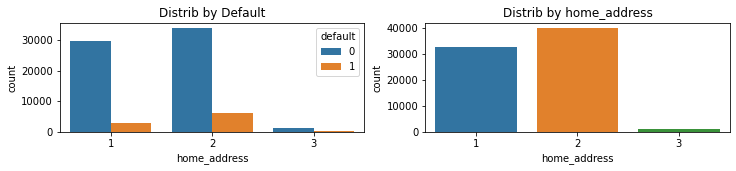

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='home_address', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='home_address', ax=ax[1]).set_title('Distrib by home_address')
plt.show()

In [63]:
percent_of_target(data[(data['sample'] == 1)]['home_address'], data[(data['sample'] == 1)]['default'])

default,0,1
home_address,,
1,0.907104,0.092896
2,0.844854,0.155146
3,0.883943,0.116057


#### region_rating

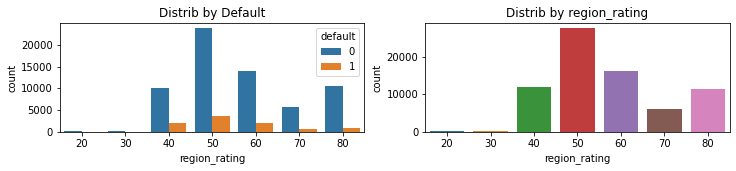

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='region_rating', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='region_rating', ax=ax[1]).set_title('Distrib by region_rating')
plt.show()

In [65]:
percent_of_target(data[(data['sample'] == 1)]['region_rating'], data[(data['sample'] == 1)]['default'])

default,0,1
region_rating,,
20,0.786408,0.213592
30,0.810000,0.190000
40,0.830298,0.169702
50,0.863859,0.136141
60,0.871166,0.128834
70,0.907566,0.092434
80,0.926846,0.073154


### Date column

In [66]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [621]:
data['clients_count_by_day'] = data.groupby('app_date')['client_id'].transform('count')
data['week_num'] = data['app_date'].dt.isocalendar().week
data['month_num'] = data['app_date'].dt.month

### Correcation check

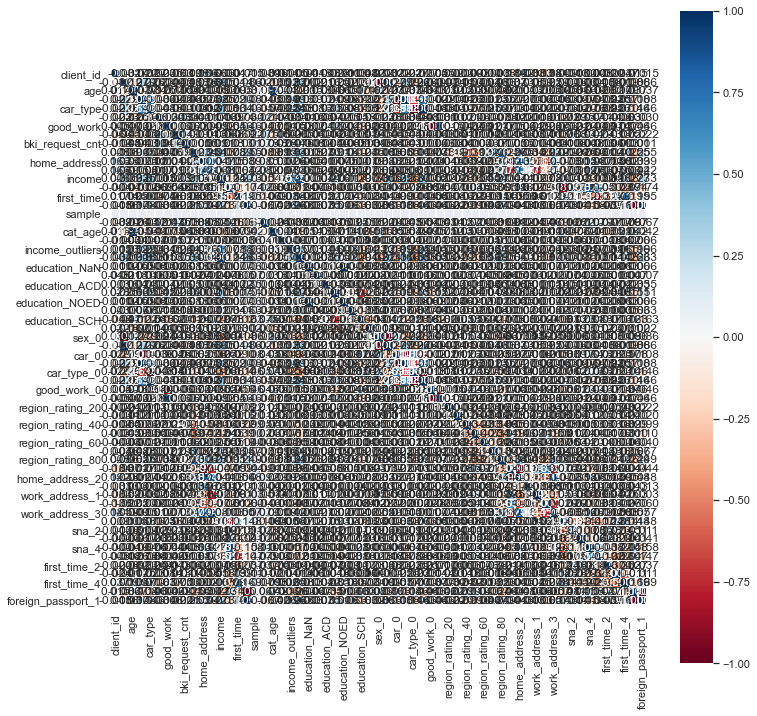

## Modeling

### read data and apply processing function

In [719]:
data = df_test.append(df_train, sort=False).reset_index(drop=True)
new_data = main_daraframe_processing(data)
display(new_data.sample(5))

,client_id,decline_app_cnt,score_bki,bki_request_cnt,sample,default,age_log,income_log,education_NaN,cat_education,score_bki_outliers,income_outliers,bki_request_cnt_outliers,car_and_type,week_num,sex_num,car_num,car_type_num,foreign_passport_num,education_ACD,education_GRD,education_NOED,education_PGR,education_SCH,education_UGR,sex_F,sex_M,car_N,car_Y,car_type_N,car_type_Y,good_work_0,good_work_1,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_N,foreign_passport_Y,cat_age_0,cat_age_1,cat_age_2,cat_age_3,cat_age_4,cat_age_5,cat_age_6,cat_age_7,cat_age_8,cat_age_9,cat_age_10,car_sex_FN,car_sex_FY,car_sex_MN,car_sex_MY,car_and_type_0,car_and_type_1,car_and_type_2,month_num_1,month_num_2,month_num_3,month_num_4
8479,94515,0,-2.022267,2,0,0,3.555348,9.798183,0,5,0,0,0,1,15,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
70355,24488,0,-1.855787,2,1,0,3.931826,10.819798,0,1,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
109469,69897,0,-2.738300,0,1,0,3.806662,10.308986,0,5,0,0,0,0,12,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
14224,85320,0,-1.920870,1,0,0,3.555348,11.512935,0,1,0,1,0,2,14,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
62151,71757,0,-1.469895,0,1,0,3.178054,11.002117,0,1,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


### normalization and balansing

Deleting all non_numeric columns and split to train and test

In [720]:
new_data = new_data._get_numeric_data()
cols = new_data.drop(columns=['sample'], axis=1).columns.to_list()
train_data = new_data.query('sample == 1')[cols]
test_data = new_data.query('sample == 0')[cols].drop(['default'], axis=1)

Normalize train and test

In [721]:
X, y = normalize(train_data, test_data)

Split

In [722]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=SEED)

SMOTE

In [723]:
sm = SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

RandomOverSampler

In [724]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=SEED)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

### Models

#### LR (basic - no balance)

0.04536082474226804
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12933
           1       0.39      0.02      0.05      1827

    accuracy                           0.87     14760
   macro avg       0.63      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760

[0.06157635 0.06234414 0.0575     0.06699752 0.06716418 0.06218905
 0.05018821 0.05223881 0.04282116 0.05479452]


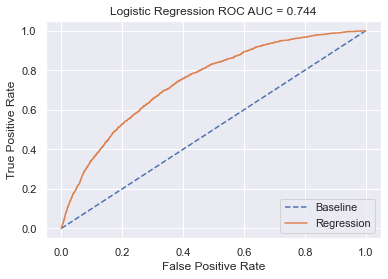

In [725]:
model(X_train, X_valid, y_train, y_valid)

#### LR with SMOTE

0.34192747828484765
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.68     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.68      0.73     14760

[0.66562652 0.68444014 0.6923516  0.68650413 0.69264237 0.69174504
 0.6872892  0.68004224 0.68983957 0.6951748 ]


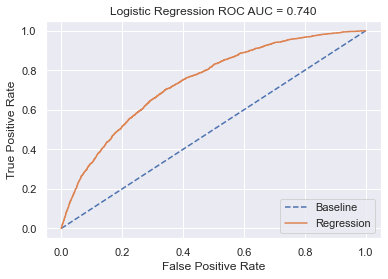

In [726]:
model(X_train_oversampled, X_valid, y_train_oversampled, y_valid)

#### LR with RandomOverSampler

0.3411973271512342
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760

[0.66931191 0.67272727 0.66814886 0.67022102 0.67045455 0.6729026
 0.67048655 0.66918166 0.66756914 0.67908701]


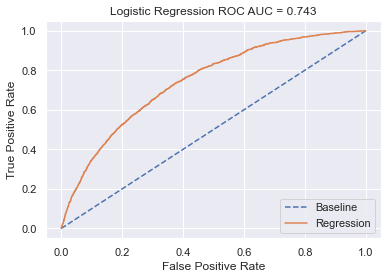

In [727]:
model(X_train_ros, X_valid, y_train_ros, y_valid)

#### LR with class_weight param = 'balanced'

0.3402342685916644
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760

[0.34341398 0.34390076 0.32164531 0.35360963 0.35273855 0.33916555
 0.34045439 0.33647376 0.34670202 0.3479174 ]


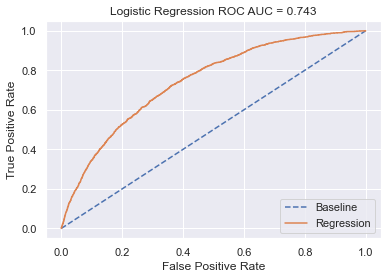

In [728]:
model(X_train, X_valid, y_train, y_valid, 'balanced')

In [647]:
C = np.logspace(0, -2, 10)       # [1, 1e-1, 1e-2, 1e-3]
iters = [15, 25, 50, 75]
epsilon_stop = [1e-4]
# class_weight = [None]
class_weight = ['balanced']
param_grid = [
    {'C': C,
     'penalty': ['l1'],
     'solver': ['liblinear'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol': epsilon_stop},
    {'C': C,
     'penalty': ['l2'],
     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop},
    {'C': C,
     'penalty': ['elasticnet'],
     'solver': ['saga'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop},
    {'C': ['none'],
     'penalty': ['none'],
     'solver': ['lbfgs', 'sag'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop}]

X_train, y_train = X_train, y_train
# X_train, y_train = X_train_ros, y_train_ros
# X_train, y_train = X_train_oversampled, y_train_oversampled

model = LogisticRegression()
model.fit(X_train, y_train)

grid_search = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_parameters = best_model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 1240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 75
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'lbfgs'
	tol: 0.0001
	verbose: 0
	warm_start: False


C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3428492621707351
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.68     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.68      0.73     14760



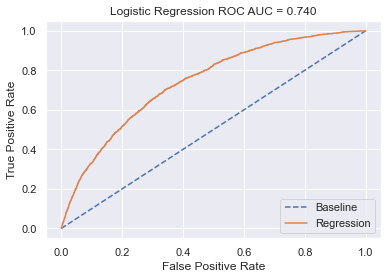

[0.6658218  0.68424113 0.69202244 0.6865815  0.69189085 0.69111639
 0.68646356 0.67959301 0.6898988  0.69531702]


In [729]:
LogReg = LogisticRegression(C=0.35938136638046275, class_weight=None, max_iter= 75, multi_class='auto', 
                            penalty= 'l1', random_state=42, solver='liblinear', tol=0.0001)
LogReg.fit(X_train_oversampled, y_train_oversampled)

y_pred = LogReg.predict(X_valid)
y_pred_proba = LogReg.predict_proba(X_valid)

Y_pred = LogReg.predict(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)
f1_score_basic = f1_score(y_valid, y_pred)
classification_report_basic = classification_report(y_valid, y_pred)
print(f1_score_basic)
print(classification_report_basic)
    
roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:,1])
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(cross_val_score(LogReg, X_train_oversampled, y_train_oversampled, scoring='f1', cv=10))

C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3403733478675569
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



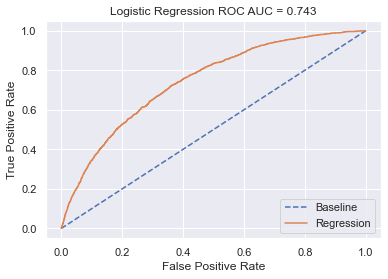

C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

[0.66569172 0.68430745 0.69266622 0.68669034 0.6926499  0.69167933
 0.68677718 0.67984645 0.68952345 0.69523351]


C:\Users\docke\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [650]:
LogReg = LogisticRegression(C=1, class_weight='balanced', max_iter=100, multi_class='auto', 
                            penalty= 'l2', random_state=None, solver='lbfgs', tol=0.0001, 
                            intercept_scaling=1)
LogReg.fit(X_train, y_train)

y_pred = LogReg.predict(X_valid)
y_pred_proba = LogReg.predict_proba(X_valid)

Y_pred = LogReg.predict(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)
f1_score_basic = f1_score(y_valid, y_pred)
classification_report_basic = classification_report(y_valid, y_pred)
print(f1_score_basic)
print(classification_report_basic)
    
roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:,1])
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(cross_val_score(LogReg, X_train_oversampled, y_train_oversampled, scoring='f1', cv=10))